Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/20 - ViT


Validation: 100%|██████████| 12/12 [00:18<00:00,  1.56s/it]


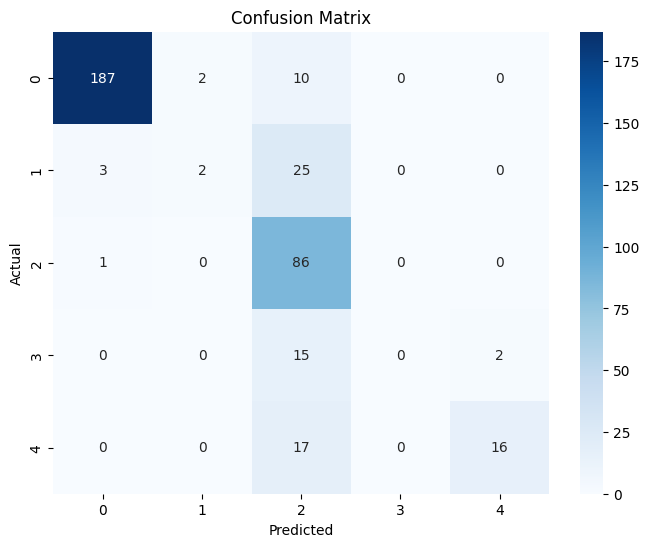

Train Loss: 1.1785 | Train F1: 0.4758
Val Loss: 0.6963 | Val F1: 0.7580
✅ Saved new best model.

Epoch 2/20 - ViT


Validation: 100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


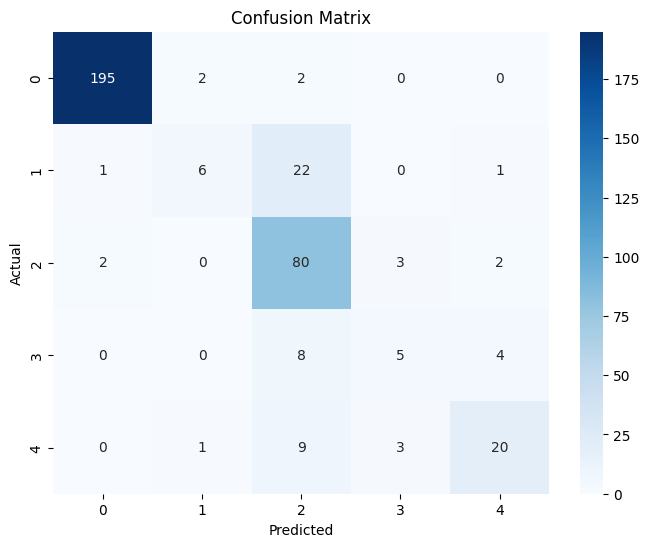

Train Loss: 0.9496 | Train F1: 0.5989
Val Loss: 0.5564 | Val F1: 0.8189
✅ Saved new best model.

Epoch 3/20 - ViT


Validation: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it]


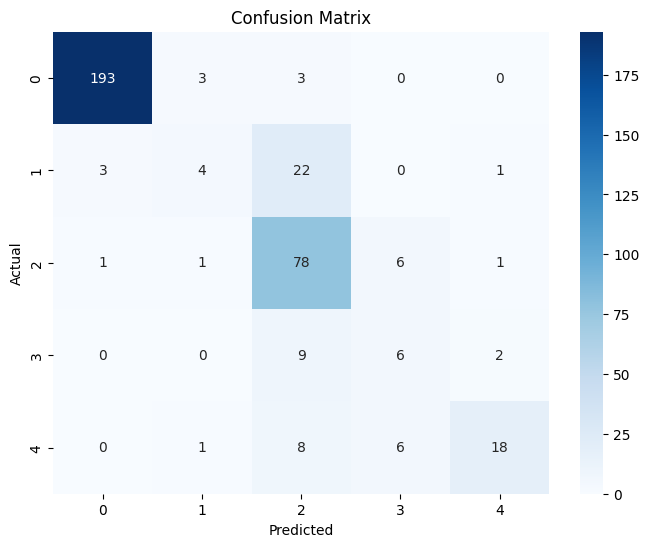

Train Loss: 0.8617 | Train F1: 0.6352
Val Loss: 0.5167 | Val F1: 0.8009
✅ Saved new best model.

Epoch 4/20 - ViT


Validation: 100%|██████████| 12/12 [00:16<00:00,  1.36s/it]


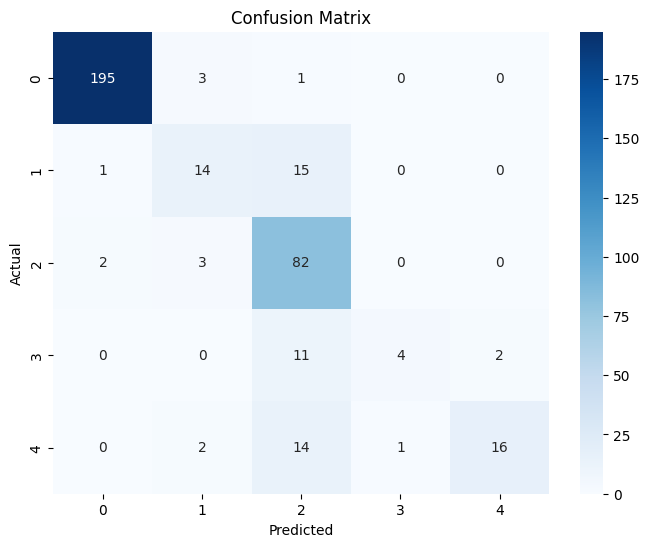

Train Loss: 0.7870 | Train F1: 0.6771
Val Loss: 0.5052 | Val F1: 0.8374
✅ Saved new best model.

Epoch 5/20 - ViT


Training:  56%|█████▌    | 95/171 [01:12<00:49,  1.54it/s]

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import datasets
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification

# Configuration
train_csv_path = '/kaggle/input/aptos2019/train_1.csv'
val_csv_path = '/kaggle/input/aptos2019/test.csv'
train_images_path = '/kaggle/input/aptos2019/train_images/train_images'
val_images_path = '/kaggle/input/aptos2019/test_images/test_images'
additional_dataset_1 = '/kaggle/input/diabetic-retinopathy-resized-arranged'
additional_dataset_2 = '/kaggle/input/diabetic-retinopathy-dataset'
num_classes = 5

# Class distribution based on dataset limits
class_limits = {
    0: 190,  # No DR
    1: 370,  # Mild DR
    2: 900,  # Moderate DR
    3: 190,  # Severe DR (limited by dataset 1)
    4: 290   # Proliferative DR
}

def get_data_loaders():
    class DRDataset(Dataset):
        def __init__(self, csv_file, root_dir, transform=None):
            self.df = pd.read_csv(csv_file)
            self.root_dir = root_dir
            self.transform = transform

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            img_id = self.df.iloc[idx]['id_code']
            img_path = os.path.join(self.root_dir, f'{img_id}.png')
            image = Image.open(img_path).convert('RGB')
            label = int(self.df.iloc[idx]['diagnosis'])
            if self.transform:
                image = self.transform(image)
            return image, label

    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor()
    ])
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    train_dataset_csv = DRDataset(train_csv_path, train_images_path, train_transform)
    train_dataset_1 = datasets.ImageFolder(root=additional_dataset_1, transform=train_transform)
    train_dataset_2 = datasets.ImageFolder(root=additional_dataset_2, transform=train_transform)
    val_dataset = DRDataset(val_csv_path, val_images_path, val_transform)

    def filter_dataset(dataset):
        class_counts = {k: 0 for k in class_limits.keys()}
        indices = []
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            if class_counts[label] < class_limits[label]:
                indices.append(idx)
                class_counts[label] += 1
        return Subset(dataset, indices)
    
    train_dataset_csv = filter_dataset(train_dataset_csv)
    train_dataset_1 = filter_dataset(train_dataset_1)
    train_dataset_2 = filter_dataset(train_dataset_2)
    
    train_dataset = ConcatDataset([train_dataset_csv, train_dataset_1, train_dataset_2])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
    return train_loader, val_loader

train_loader, val_loader = get_data_loaders()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Selection
def get_vit_model():
    model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
    return model.to(device)

# Training & Evaluation Functions
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return running_loss / len(dataloader), f1_score(all_labels, all_preds, average='weighted')

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate and display confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return running_loss / len(dataloader), f1_score(all_labels, all_preds, average='weighted')

# Training Loop
def train_vit():
    model = get_vit_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    best_val_loss = float('inf')
    early_stop_counter = 0
    early_stop_patience = 20
    
    for epoch in range(1, 21):
        print(f"\nEpoch {epoch}/20 - ViT")
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_f1 = evaluate(model, val_loader, criterion)
        print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_vit_model.pth")
            print("✅ Saved new best model.")
        else:
            early_stop_counter += 1
        
        if early_stop_counter >= early_stop_patience:
            print("🔥 Early stopping triggered.")
            break
    print("🎉 Training Complete for ViT.")

# Train ViT model
train_vit()


In [ ]:
pip install matplotlib seaborn scikit-learn


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# Function to plot F1 Score Comparison
def plot_f1_score(train_f1_scores, val_f1_scores):
    epochs = range(1, len(train_f1_scores) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_f1_scores, label="Train F1 Score", marker="o")
    plt.plot(epochs, val_f1_scores, label="Val F1 Score", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Train vs Validation F1 Score")
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot Confusion Matrix
def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Function to plot ROC Curves for each class
def plot_roc_curve(model, dataloader, num_classes=5):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_labels = np.hstack(all_labels)
    
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Each Class")
    plt.legend()
    plt.show()


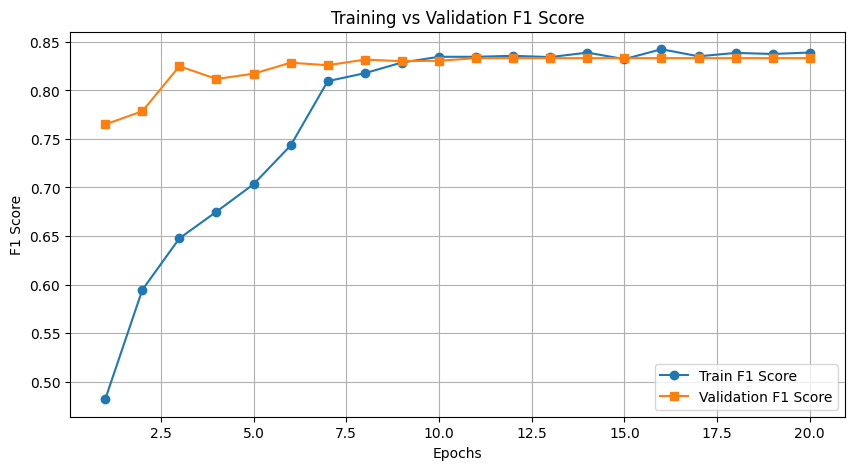

In [3]:
# Data from training logs
epochs = list(range(1, 21))
train_f1_scores = [0.4818, 0.5945, 0.6476, 0.6751, 0.7034, 0.7433, 0.8096, 0.8178, 0.8288, 0.8347,
                   0.8347, 0.8357, 0.8344, 0.8390, 0.8323, 0.8425, 0.8352, 0.8387, 0.8376, 0.8391]
val_f1_scores = [0.7650, 0.7786, 0.8250, 0.8118, 0.8173, 0.8286, 0.8260, 0.8318, 0.8302, 0.8306,
                 0.8333, 0.8333, 0.8333, 0.8333, 0.8333, 0.8333, 0.8333, 0.8333, 0.8333, 0.8333]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_scores, label="Train F1 Score", marker='o')
plt.plot(epochs, val_f1_scores, label="Validation F1 Score", marker='s')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training vs Validation F1 Score")
plt.legend()
plt.grid()
plt.show()


In [13]:
import torch
from transformers import ViTForImageClassification

# Define model path
model_path = "/kaggle/input/visualization/best_vit_model.pth"  # Replace with the actual model path

# Load model
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels = 5,
    ignore_mismatched_sizes=True
)

# Load the state dict, removing "module." prefix if necessary
state_dict = torch.load(model_path, map_location=torch.device("cpu"))

# Check if keys are prefixed with "module."
new_state_dict = {}
for key, value in state_dict.items():
    new_key = key.replace("module.", "")  # Remove "module." prefix
    new_state_dict[new_key] = value

# Load corrected state dict
model.load_state_dict(new_state_dict, strict=False)

# Set model to evaluation mode
model.eval()

print("Model loaded successfully!")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-14ca6032e37d>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. Th

Model loaded successfully!


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm  # For progress tracking

# Define class names (Update with your actual class labels)
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"]

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
pred_labels = []

# Run model inference
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        # Extract inputs and labels correctly
        if isinstance(batch, dict):  # If dataset returns a dictionary (like Hugging Face datasets)
            inputs, labels = batch["pixel_values"], batch["labels"]
        else:  # If dataset returns a tuple
            inputs, labels = batch

        # Move tensors to the correct device
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs).logits
        predictions = torch.argmax(outputs, dim=1)

        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(true_labels, pred_labels, target_names=class_names))

Evaluating: 0it [00:00, ?it/s]


TypeError: 'ellipsis' object is not iterable